#### CSCI-GA 3033-012 Vision meets Machine Learning Assignment 3

Rohan Mahadev - rm5310

Part 2 - Classifying video into one of 4 categories

# My first observations while trying to solve this problem is:
1. If we're trying to classify the whole video into one category, we need to figure out what makes each category distinct from each other.
2. Looking at the videos, the main distinction is that the objects in different categories are different. For e.g., there is a chess board and chess pieces in the "chess" videos, playing cards in the "cards" category etc.
3. So what I think we need is an object classifier for the frames, and the temporal aspect of the videos don't play a big role.
4. Also, the hand movements in the 4 categories are pretty much the same, so I don't think visually, using the hand masks gives us any useful information about the category of video, so I will stick with the RGB frames.
5. This is just my initial observation and based on results for this we can decide on further approaches.
6. So I'll use the backbone of the MaskRCNN model, and finetune it to classify every RGB frame into the 4 classes.

In [1]:
import os
import random
import time
import csv

import numpy as np

import torch
import torchvision

from PIL import Image
import cv2


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython import display


from engine import train_one_epoch, evaluate
import utils

%load_ext autoreload
%autoreload 2

# from torchvision import transforms
# transform = transforms.Compose([transforms.ToTensor()])  # Convert image to PyTorch Tensor
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


## Combine datapoints from the subcategories into 4 classes
#### Done using bash commands

In [2]:
# !mv egohands/CLASSIFICATION_DATA/CARDS_*/* egohands/CLASSIFICATION_DATA/cards/
# !mv egohands/CLASSIFICATION_DATA/CHESS_*/* egohands/CLASSIFICATION_DATA/chess/
# !mv egohands/CLASSIFICATION_DATA/PUZZLE_*/* egohands/CLASSIFICATION_DATA/puzzle/
# !mv egohands/CLASSIFICATION_DATA/JENGA_*/* egohands/CLASSIFICATION_DATA/jenga/

In [2]:
transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

In [3]:
dataset=torchvision.datasets.ImageFolder(root="./egohands/CLASSIFICATION_DATA/",transform=transforms)

In [4]:
dataset.classes

['cards', 'chess', 'jenga', 'puzzle']

# Using same model, but only using output of backbone

In [5]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [6]:
model = get_model_instance_segmentation(num_classes=2)
state_dict = torch.load('finetuned_better_2.pt')
model.load_state_dict(state_dict)
# move model to the right device
model.to(device)
model.eval();

# We can see that the backbone is a Resnet50 and since the backbone wasn't trained during finetuning, using the resnet50 from torchvision would be equivalent to using the intermediate activations from this model

## So I'll be using the torchvision model for simplicity

In [ ]:
acts = model.backbone.body.forward(dataset[0][0].unsqueeze(0).cuda())

### Because doing the above is not too code-friendly :)

In [7]:
classifier = torchvision.models.resnet50(pretrained=True)

In [8]:
classifier.fc

Linear(in_features=2048, out_features=1000, bias=True)

### The above is equivalent to using the backbone of the Mask-RCNN

In [9]:
classifier.fc = torch.nn.Linear(in_features=2048, out_features=4, bias=True)

# My approach for this task initially is to run every RGB frame from the videos through the backbone and classify the frame into one of the 4 classes directly. This will act as a baseline

# For this we will finetune only the fully connected layer of the ResNet to classify the frame into one of the 4 classes

In [10]:
for params in classifier.fc.parameters():
    params.requires_grad_(True)

In [11]:
classifier.to(device);

In [12]:
batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [13]:
len(train_loader)

99

In [18]:
len(validation_loader)

25

In [14]:
def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            fx = model(x)

            loss = criterion(fx, y)
            
            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def train(model, iterator, optimizer, criterion, sched=None):
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch_idx,(x, y) in enumerate(iterator):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        fx = model(x)
        
        loss = criterion(fx, y)
        
        acc = calculate_accuracy(fx, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        lr_sched_test = scheduler.get_lr()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(classifier.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=5)

In [16]:
EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(classifier, train_loader, optimizer, criterion, scheduler)
    valid_loss, valid_acc = evaluate(classifier, validation_loader, criterion)
    print("[EPOCH " + str(epoch)+"]")
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(classifier.state_dict(), 'hands-classifier-2.pth')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

[EPOCH 0]
Epoch: 01 | Epoch Time: 2m 46s
	Train Loss: 0.184 | Train Acc: 96.53%
	 Val. Loss: 0.009 |  Val. Acc: 99.88%
[EPOCH 1]
Epoch: 02 | Epoch Time: 2m 27s
	Train Loss: 0.004 | Train Acc: 99.97%
	 Val. Loss: 0.006 |  Val. Acc: 99.88%
[EPOCH 2]
Epoch: 03 | Epoch Time: 2m 23s
	Train Loss: 0.003 | Train Acc: 100.00%
	 Val. Loss: 0.003 |  Val. Acc: 99.88%
[EPOCH 3]
Epoch: 04 | Epoch Time: 2m 1s
	Train Loss: 0.002 | Train Acc: 99.97%
	 Val. Loss: 0.005 |  Val. Acc: 99.88%
[EPOCH 4]
Epoch: 05 | Epoch Time: 1m 43s
	Train Loss: 0.003 | Train Acc: 99.94%
	 Val. Loss: 0.007 |  Val. Acc: 99.88%


# The backbone is now finetuned, so now we evaluate it

In [128]:
dataset.classes

['cards', 'chess', 'jenga', 'puzzle']

# Evaluation:

## The procedure is that for every frame we calculate the class probabilities and keep a running average of all the class probabilities for every frame

## At the end of running the model through every frame, the max avg. probability will be our final prediction for the video

In [17]:
vids = os.listdir("./egohands/all_vids/")

In [18]:
state_d = torch.load("hands-classifier-2.pth")
classifier.load_state_dict(state_d)
classifier.to(device);

In [138]:
correct = 0
vidcount = 0
for vid in vids:
    print("...evaluating",vid+" score-"+str(correct)+"/"+str(vidcount))
    capture = cv2.VideoCapture(os.path.join("./egohands/all_vids", vid))
    frame_count = 0
    result_probs = [0]*4
    while True:
        ret, frame = capture.read()
        # Bail out when the video file ends
        if not ret:
            break
        cv2_im = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        pil_im = Image.fromarray(cv2_im)
        img = transforms(pil_im)
        probs = classifier(img.to(device).unsqueeze(0))
        pred_idx = probs.argmax()
        result_probs[pred_idx] += 1
        frame_count += 1
    pred = result_probs.index(max(result_probs))
    classname = dataset.classes[pred]
    true_label = vid[0:vid.find("_")]
    if classname == true_label:
        correct += 1
    vidcount +=1

...evaluating chess_courtyard_B_T.mp4 score-0/0
...evaluating puzzle_livingroom_H_S.mp4 score-1/1
...evaluating puzzle_courtyard_T_H.mp4 score-2/2
...evaluating cards_courtyard_S_H.mp4 score-3/3
...evaluating jenga_courtyard_B_H.mp4 score-4/4
...evaluating cards_livingroom_T_B.mp4 score-4/5
...evaluating jenga_office_S_B.mp4 score-5/6
...evaluating cards_livingroom_H_S.mp4 score-5/7
...evaluating puzzle_courtyard_B_S.mp4 score-6/8
...evaluating cards_livingroom_S_H.mp4 score-7/9
...evaluating cards_office_T_H.mp4 score-8/10
...evaluating chess_courtyard_T_B.mp4 score-9/11
...evaluating jenga_livingroom_S_T.mp4 score-10/12
...evaluating jenga_livingroom_T_S.mp4 score-10/13
...evaluating jenga_courtyard_T_S.mp4 score-10/14
...evaluating chess_livingroom_H_T.mp4 score-10/15
...evaluating cards_courtyard_H_S.mp4 score-11/16
...evaluating jenga_courtyard_H_B.mp4 score-12/17
...evaluating chess_office_B_S.mp4 score-12/18
...evaluating jenga_livingroom_H_B.mp4 score-13/19
...evaluating jenga_

In [139]:
print(correct/vidcount)

0.75


# This approach gives us an accuracy of 75% 
## but takes a lot of time to process, since we run our feature extractor model on every frame
## I think the score is low because there are frames in the video which act as outliers which drastically change the average prediction

# By outliers, I mean the following scenario:

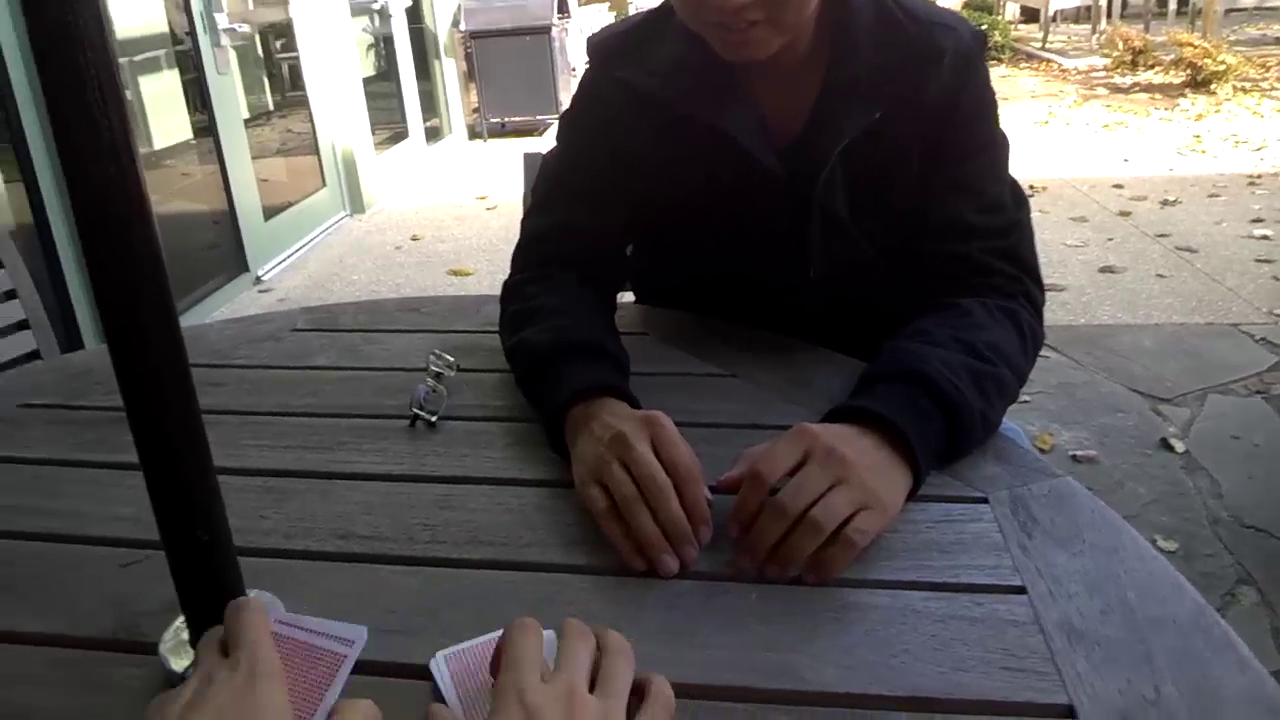

In [1]:
import IPython.display as ipd
ipd.Image("./out.png")

# And a representative image (to me) is as follows:

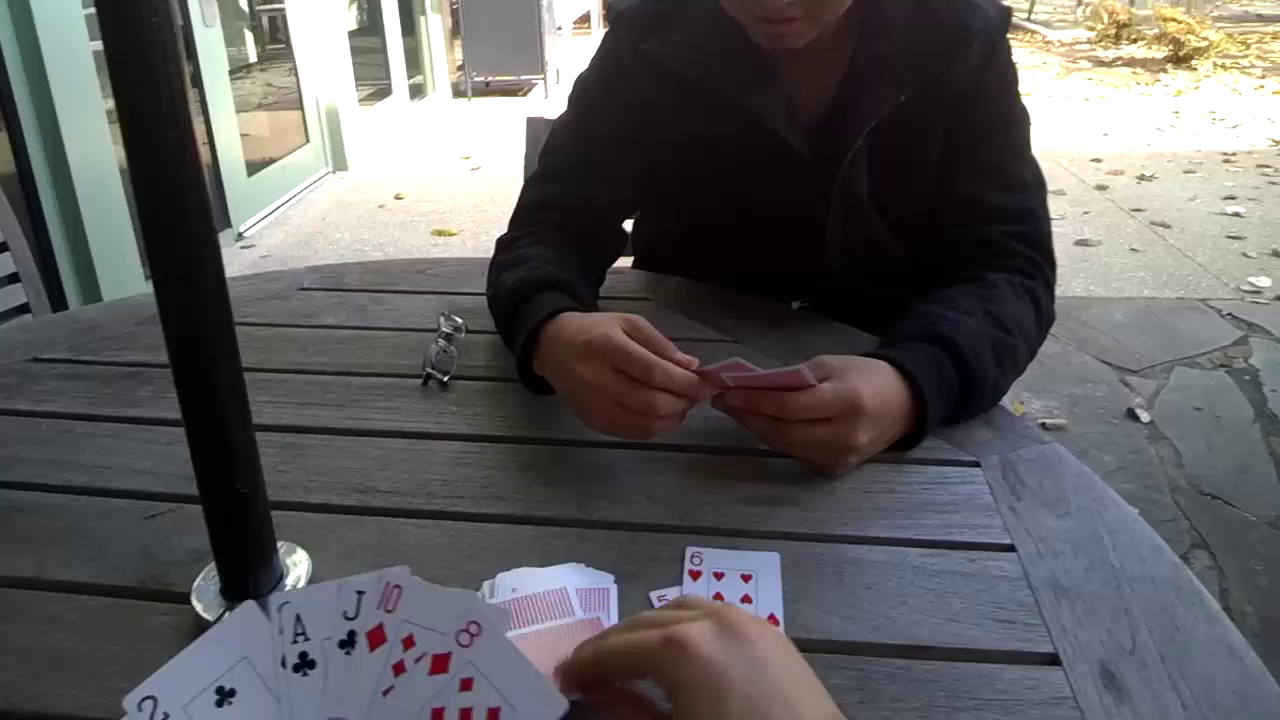

In [2]:
import IPython.display as ipd
ipd.Image("./rep.png")

# So the next attempt will be to process only 1 in 100 frames (which potentially would smoothen the predictions and hopefully get rid of the outliers)

In [25]:
state_d = torch.load("hands-classifier-1.pth")
classifier.load_state_dict(state_d)
classifier.to(device);

In [26]:
vids = os.listdir("./egohands/all_vids/")

In [27]:
correct = 0
vidcount = 0
frame_rate = 100
for vid in vids:
    print("...evaluating",vid+" score-"+str(correct)+"/"+str(vidcount))
    capture = cv2.VideoCapture(os.path.join("./egohands/all_vids", vid))
    frame_count = 0
    result_probs = [0]*4
    while True:
        ret, frame = capture.read()
        # Bail out when the video file ends
        if not ret:
            break
        if frame_count % frame_rate == 0:
            cv2_im = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            pil_im = Image.fromarray(cv2_im)
            img = transforms(pil_im)
            probs = classifier(img.to(device).unsqueeze(0))
            pred_idx = probs.argmax()
            result_probs[pred_idx] += 1
        frame_count += 1
    pred = result_probs.index(max(result_probs))
    classname = dataset.classes[pred]
    true_label = vid[0:vid.find("_")]
    if classname == true_label:
        correct += 1
    vidcount +=1

...evaluating chess_courtyard_B_T.mp4 score-0/0
...evaluating puzzle_livingroom_H_S.mp4 score-1/1
...evaluating puzzle_courtyard_T_H.mp4 score-2/2
...evaluating cards_courtyard_S_H.mp4 score-3/3
...evaluating jenga_courtyard_B_H.mp4 score-4/4
...evaluating cards_livingroom_T_B.mp4 score-4/5
...evaluating jenga_office_S_B.mp4 score-5/6
...evaluating cards_livingroom_H_S.mp4 score-5/7
...evaluating puzzle_courtyard_B_S.mp4 score-6/8
...evaluating cards_livingroom_S_H.mp4 score-7/9
...evaluating cards_office_T_H.mp4 score-8/10
...evaluating chess_courtyard_T_B.mp4 score-9/11
...evaluating jenga_livingroom_S_T.mp4 score-10/12
...evaluating jenga_livingroom_T_S.mp4 score-10/13
...evaluating jenga_courtyard_T_S.mp4 score-10/14
...evaluating chess_livingroom_H_T.mp4 score-10/15
...evaluating cards_courtyard_H_S.mp4 score-10/16
...evaluating jenga_courtyard_H_B.mp4 score-11/17
...evaluating chess_office_B_S.mp4 score-11/18
...evaluating jenga_livingroom_H_B.mp4 score-12/19
...evaluating jenga_

In [33]:
print(35/48 * 100)

72.91666666666666


# This was not helpful because we seemed to have gotten rid of the good frames and included more outliers. So we need a more structured approach to get rid of the outliers and only include the representative frames from the video

### As discussed with Prof. Geiger, I am going to use Submodular optimization for data subset selection:
### I wrote a few papers on this topic previously. - [[1]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8659119) [[2]](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8658965)

### The basic idea is as follows: 
1. A video is a set of frames.
2. Each frame has some amount of information(sometimes referred to as "utility" which can be calculated using certain set functions like Facility Location/Disparity Min etc.).
3. But the total information in the video is not equal to the sum of information from every frame.
4. This is because the information is distributed unevenly, with some frames having more information and some having very little.
5. These kinds of distributions are called submodular functions.
6. A good thing about submodular functions is that we can use mathematical optimization techniques to find a subset of the entire set which maximizes the utility function.
7. A utility function which conveys the concept of "representation" is Facility Location.
8. In this context, we find the subset of frames from our video which are the most "representative" using this Facility Location function
9. This will potentially get rid of the outliers and we can run our classifier on only the most representative frames.

# I, along with my collaborators at my previous lab, wrote an open source C++ library which does this submodular optimization on videos called "vis-dss" which gives us a subset of frames from the video which are the most representative. The code can be found here - https://github.com/rowhanm/vis-dss

# Let me know if running the code is an issue, I've tried to make it as user friendly as possible

# What this code does is essentially create a "highlights" video from our original video with only the representative frames which would hopefully remove all the outliers which were making our predictions bad.

In [ ]:
# Code to create subsets (BASH script):
# for file in /scratch/rm5310/myjupyter/Vision-ML/egohands/all_vids/*
# do
#   fname=$(echo $file |  sed -r "s/.+\/(.+)\..+/\1/")
#   echo $fname
#   /scratch/rm5310/myjupyter/Vision-ML/vis-dss/build/SimpleVideoSummExample -videoFile $file -videoSaveFile /scratch/rm5310/myjupyter/Vision-ML/egohands/subset_vids/$fname.avi -summaryModel 0 -segmentType 0 -summaryAlgo 0 -budget 10
# done

#### Highlights video stored in a different folder

In [20]:
vids = os.listdir("./egohands/subset_vids/")

### Running the same evaluation code on it

In [22]:
correct = 0
vidcount = 0
for vid in vids:
    print("...evaluating",vid+" score-"+str(correct)+"/"+str(vidcount))
    capture = cv2.VideoCapture(os.path.join("./egohands/subset_vids", vid))
    frame_count = 0
    result_probs = [0]*4
    while True:
        ret, frame = capture.read()
        # Bail out when the video file ends
        if not ret:
            break
        cv2_im = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        pil_im = Image.fromarray(cv2_im)
        img = transforms(pil_im)
        probs = classifier(img.to(device).unsqueeze(0))
        pred_idx = probs.argmax()
        result_probs[pred_idx] += 1
        frame_count += 1
    pred = result_probs.index(max(result_probs))
    classname = dataset.classes[pred]
    true_label = vid[0:vid.find("_")]
    if classname == true_label:
        correct += 1
    vidcount +=1

...evaluating puzzle_livingroom_S_H.avi score-0/0
...evaluating chess_courtyard_B_T.avi score-1/1
...evaluating chess_livingroom_H_T.avi score-2/2
...evaluating puzzle_office_H_B.avi score-3/3
...evaluating chess_courtyard_S_H.avi score-4/4
...evaluating chess_office_B_S.avi score-5/5
...evaluating chess_courtyard_T_B.avi score-6/6
...evaluating jenga_office_H_T.avi score-7/7
...evaluating cards_livingroom_H_S.avi score-8/8
...evaluating cards_office_T_H.avi score-9/9
...evaluating puzzle_courtyard_T_H.avi score-10/10
...evaluating jenga_courtyard_T_S.avi score-11/11
...evaluating jenga_office_T_H.avi score-12/12
...evaluating jenga_livingroom_T_S.avi score-13/13
...evaluating cards_livingroom_T_B.avi score-14/14
...evaluating chess_office_H_T.avi score-15/15
...evaluating chess_office_T_H.avi score-16/16
...evaluating cards_courtyard_H_S.avi score-17/17
...evaluating puzzle_livingroom_T_B.avi score-18/18
...evaluating puzzle_courtyard_B_S.avi score-19/19
...evaluating chess_livingroom

In [27]:
print(correct/vidcount * 100)

100.0


# Unsurprisingly, this gives us 100% accuracy on the video classification as we have gotten rid of all outliers and our initial assumption was proven to be mostly correct.
# According to me this approach is better than using a 1D conv or an LSTM because this is much more computationally cheap and the subset selection code runs entirely on the CPU with very little complex calculation 